<h1 style="text-align: center;"> ML1 project - Laser </h1>

<a id="Problem-setting"></a>
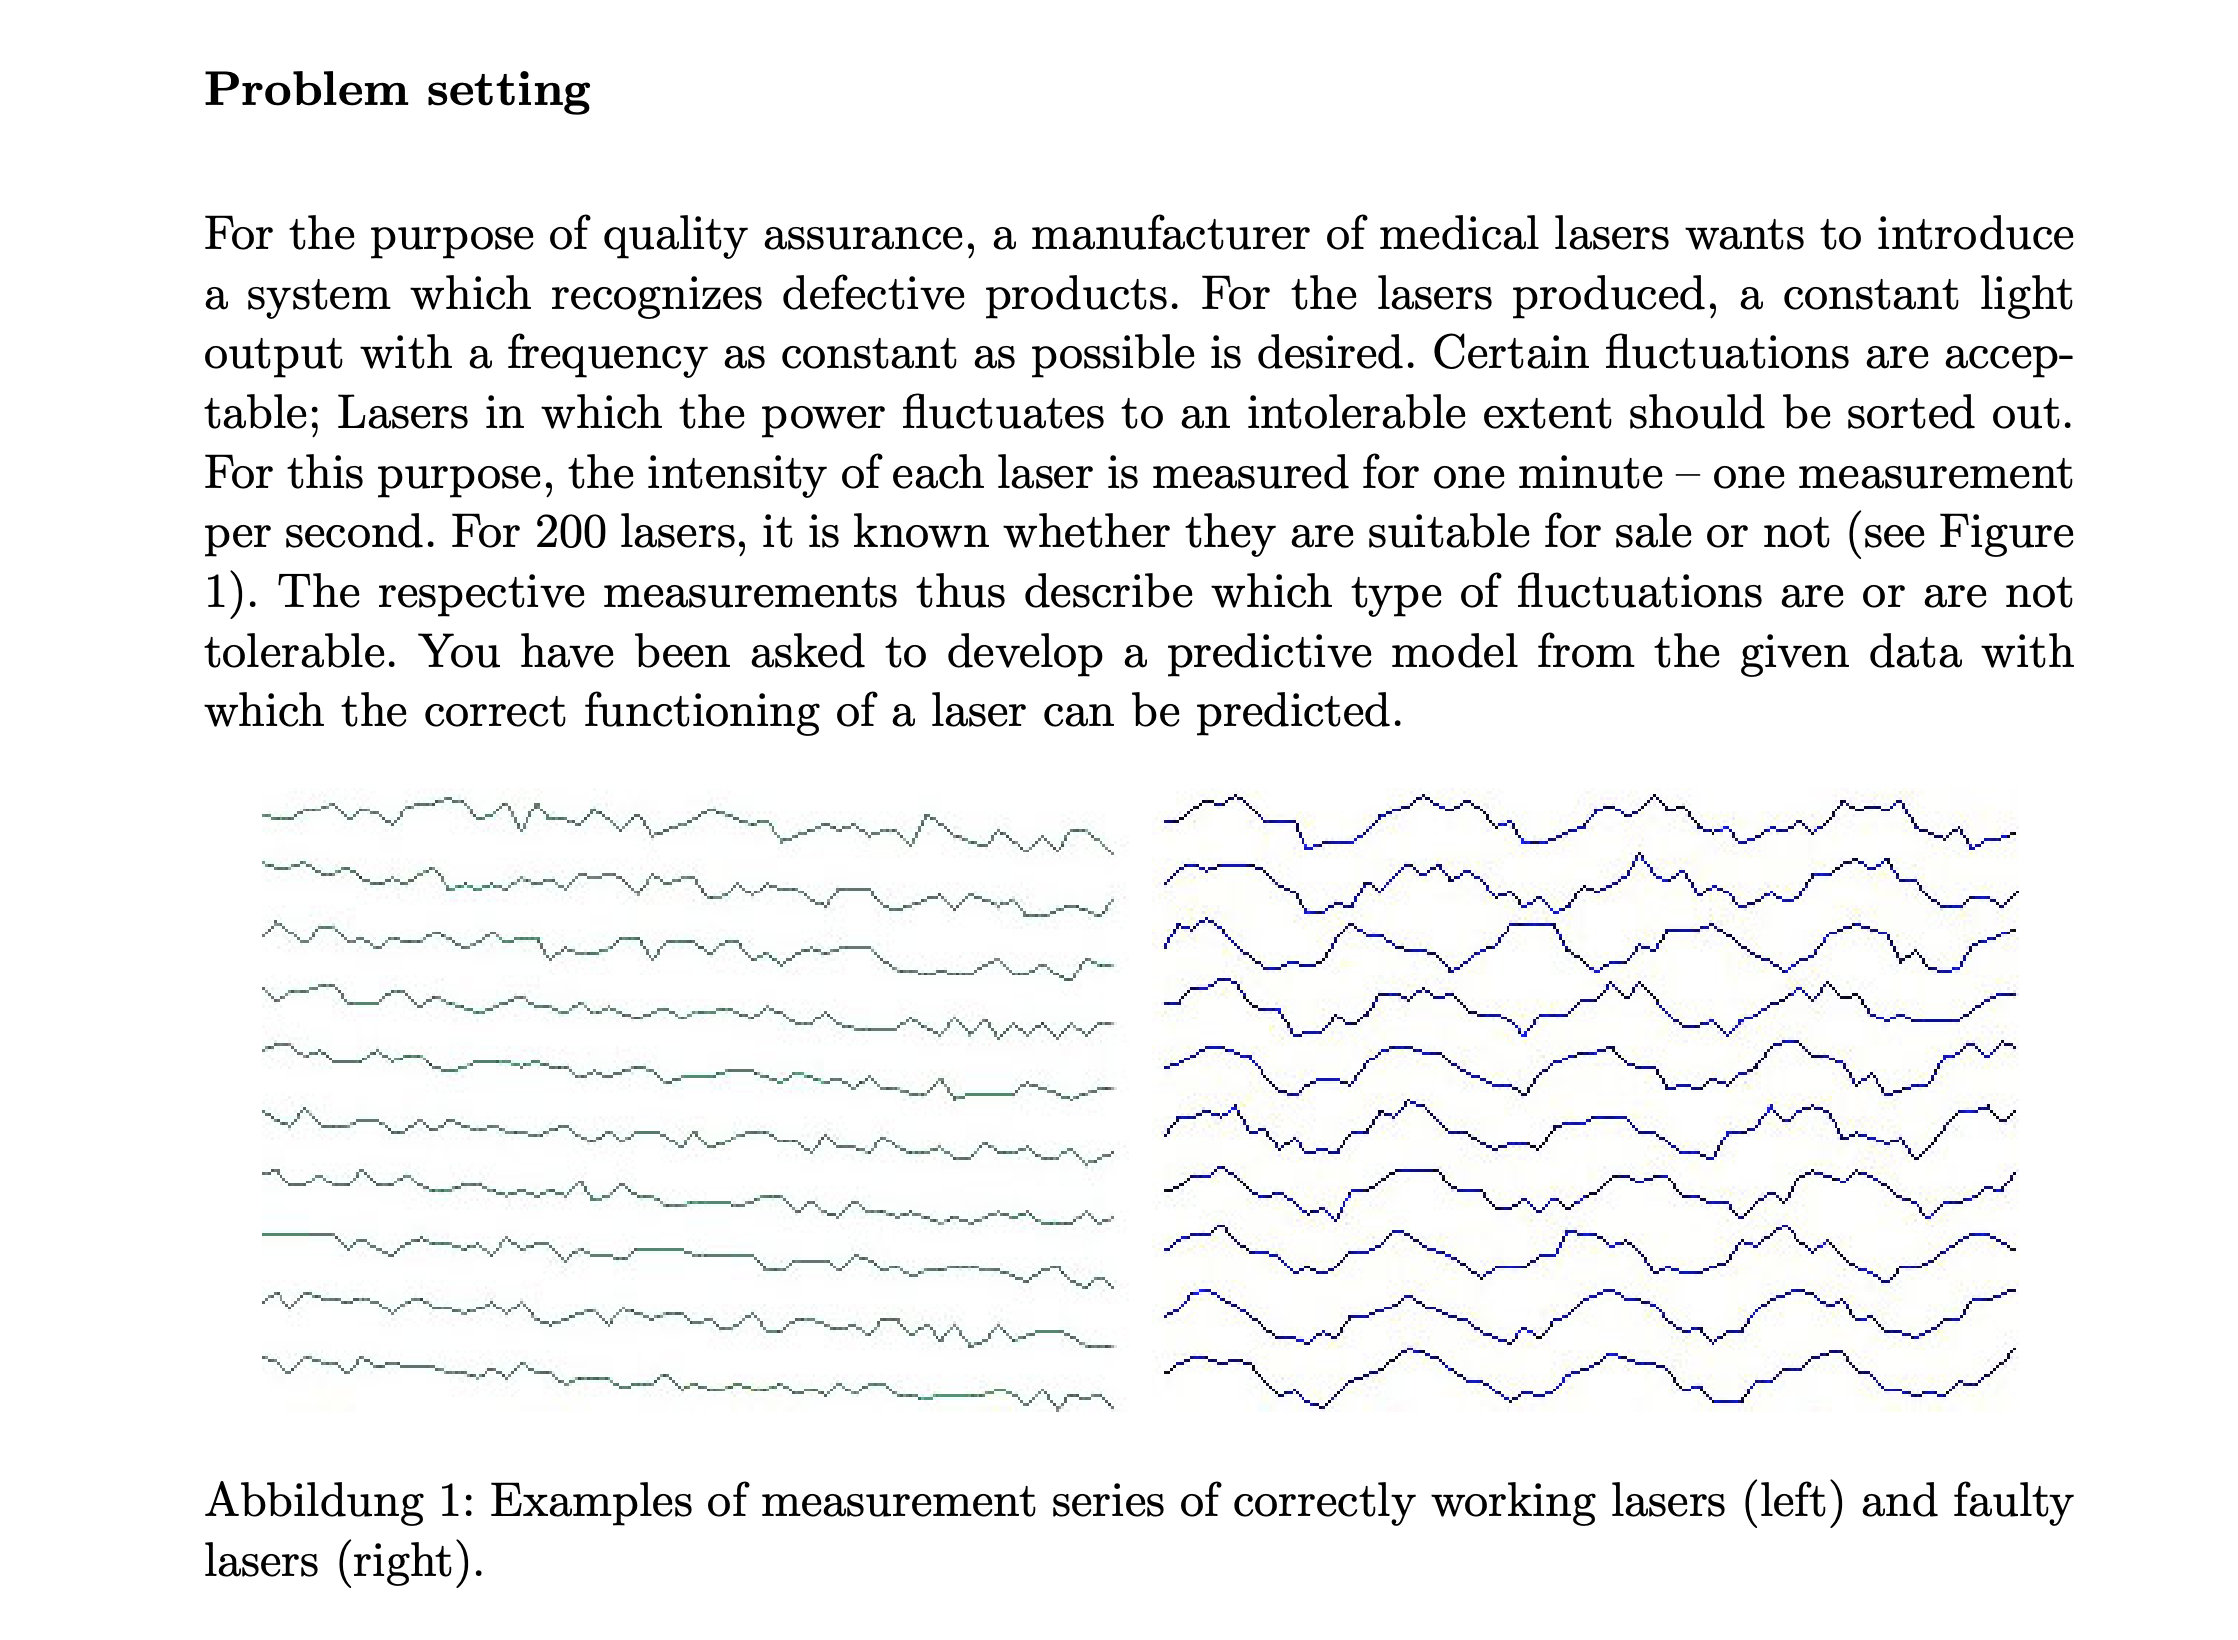
</img>

## Table of Content

0. [Problem setting](#Problem-setting)
1. [Introduction and ideas](#Introduction)
2. [Exploratory Data Analysis](#EDA)
3. [Preditive models](#Models)
    1. [Naive models](#Naive-models)
    2. [Appropriate models](#Appropriate-models)
    3. [Overkill models](#Overkill-models)
4. [Conclusions](#Conclusions)

## Introduction <a id="Introduction"></a>


The problem at hand boils down to a **binary classification** one, with the added complexity that we have time-series and not tabular data. 

The common approach for this (as I gathered from the literature I have read) is to transform the time-series data to a representation to which we can apply tabular classification models such as logistic regression or support vector machines (SVM). This transformation can be done using **distance metrics**, **intervals**, **spectral features** or **convolutions**.


### Ideas:

There are many ways we can tackles this task, all of them interesting and worth exploring. Below are some of those I found worth mentioning and potentially intersting to use.

We can classify these methods as either naive (potentially too simplistic to work well), appropriate (based on the lectures material and other sources) and overkill (definitely overengineering the task at hand, but could be fun...)

1. Naive

    1. Linear classifier on the time series as tabular data (each sample as an array)
    2. Decision tree on descriptive statistics (minimum, maximum, mean, SD, initial value, final value, etc.)


2. Appropriate

    - Distance-based
        1. Dynamic Time Wrapping (DTW) Kernel and 1-NN as **baseline** (inspiered by [source](https://link.springer.com/article/10.1007/s10462-021-10050-y))
        2. DTW Kernel and k-NN 
        3. DTW Kernel and (Gausian) SVM (on parameter tunning [source](https://en.wikipedia.org/wiki/Support-vector_machine#Parameter_selection))
        4. Time Warp Edit Distance with (Gaussian) SVM (again from [source](https://link.springer.com/article/10.1007/s10462-021-10050-y))
    
    - Interval-based
        1. Time Series Forest (TSF) (as described in [source](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97))
    
    - Frequency-based
        1. k-NN in the fourier space
        2. (Gaussian) SVM in the fourier space
        3. Random Interval Spectral Ensemble (RISE) (as described in [source](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97))
       
    - Convolution-based
        1. MiniRocket (from [source](https://arxiv.org/abs/2012.08791))


3. Overkill

    1. Convert data to image, then apply an image classifier
    2. Convert fourier space represenation to image, then apply an image classifier
    3. Time-series predictive model, then every 10s reevaluate prior (Bayesias style?)

## Exploratory Data Analysis<a id="EDA"></a>

Let's get familiar with the data we will be working with. To do so, first we wil first visualize it and explore some of it's descriptive statistics.

### Load

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
# load the .mat file (loadmat() returns a dict)
# laser_mat = loadmat("/kaggle/input/ml1-laser/laser.mat")
laser_mat = loadmat("laser.mat")

In [3]:
X = laser_mat["X"]
y = laser_mat["Y"].flatten()

In [4]:
# check if there are any missing values in the data
print(f"missing values in X: {np.isnan(X).sum()}")
print(f"missing values in y: {np.isnan(y).sum()}")

missing values in X: 0
missing values in y: 0


In [5]:
# store data in a DataFrame with DatetimeIndex
def construct_ts_df(data_array: np.ndarray):
    df = pd.DataFrame(data_array.T)
    df.index = pd.date_range("2023-01-01 00:00:00", periods=60, freq="s")
    
    return df
    
X_df = construct_ts_df(X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2023-01-01 00:00:00,29.8509,26.2727,34.1790,33.7603,34.7860,35.0122,34.2888,29.9618,35.5314,30.8171,...,25.6158,29.3423,30.3433,24.6305,31.3393,32.2096,27.8716,35.8083,33.9818,33.3759
2023-01-01 00:00:01,25.7777,31.2289,27.0398,28.0251,27.0130,34.2871,32.7982,32.7794,31.9037,28.0794,...,31.6723,32.1281,33.0853,30.1956,30.1347,33.9926,27.0351,31.0808,27.2921,25.4986
2023-01-01 00:00:02,28.8859,29.7408,29.3324,27.9612,34.6680,26.4959,32.1346,33.1450,27.8117,24.6279,...,30.2600,24.4618,28.1304,27.9076,28.3742,30.6470,28.2645,24.7077,23.2850,31.0451
2023-01-01 00:00:03,30.3456,34.2078,31.8299,23.7675,32.1062,28.2444,28.6556,32.6069,34.1000,23.9332,...,33.3391,23.8141,31.2943,25.8944,33.1679,30.9754,31.3723,33.2497,31.6800,31.5695
2023-01-01 00:00:04,25.2192,33.3289,25.8882,28.7756,33.3359,27.2509,27.8811,23.0114,35.5197,28.6604,...,30.6467,31.1505,28.7193,23.2760,27.4447,33.6320,34.9079,27.5799,27.7519,35.6331


### Visualize the data

In [7]:
label_0 = "Acceptable"
label_1 = "Not aceptable"

color_0 = "deepskyblue"
color_1 = "orangered"

In [7]:
# # plot sample data
# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16, 10))

# data_0 = X_df[np.where(y == +1)[0]].iloc[:, :6]
# data_1 = X_df[np.where(y == -1)[0]].iloc[:, :6]

# axs[0].plot(data_0, c=color_0)
# axs[1].plot(data_1, c=color_1)

# axs[0].set_title(label_0)
# axs[1].set_title(label_1)
# axs[1].set_xlabel("time (seconds)")

# fig.suptitle("Some laser intensities for each class", fontsize=22)
# fig.tight_layout()
# fig.show()

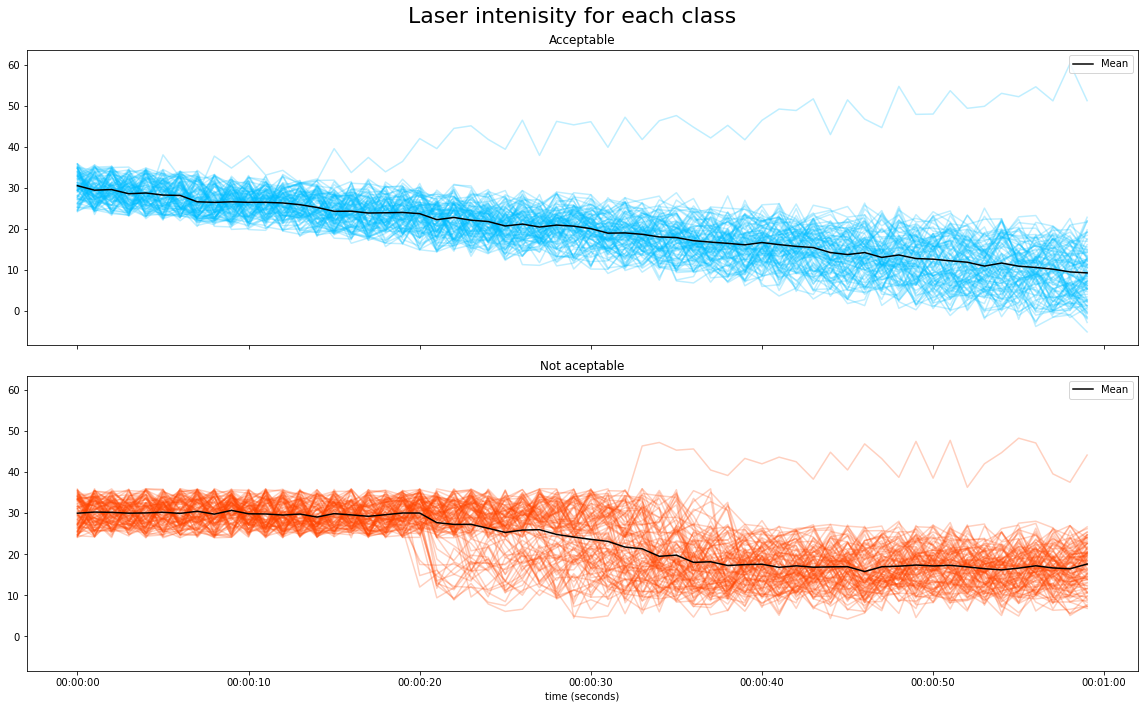

In [8]:
# plot data
def plot_data(data_df: pd.DataFrame, label_array: np.ndarray):
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 10))

    data_0 = data_df.iloc[:, np.where(label_array == +1)[0]]
    data_1 = data_df.iloc[:, np.where(label_array == -1)[0]]

    axs[0].plot(data_0, c=color_0, alpha=0.25)
    axs[0].plot(data_0.mean(axis=1), label="Mean", c="black")
    axs[1].plot(data_1, c=color_1, alpha=0.25)
    axs[1].plot(data_1.mean(axis=1), label="Mean", c="black")

    axs[0].set_title(label_0)
    axs[0].legend(loc="upper right")
    axs[1].set_title(label_1)
    axs[1].legend(loc="upper right")
    axs[1].set_xlabel("time (seconds)")

    fig.suptitle("Laser intenisity for each class", fontsize=22)
    fig.tight_layout()
    plt.show()
    
plot_data(data_df=X_df, label_array=y)

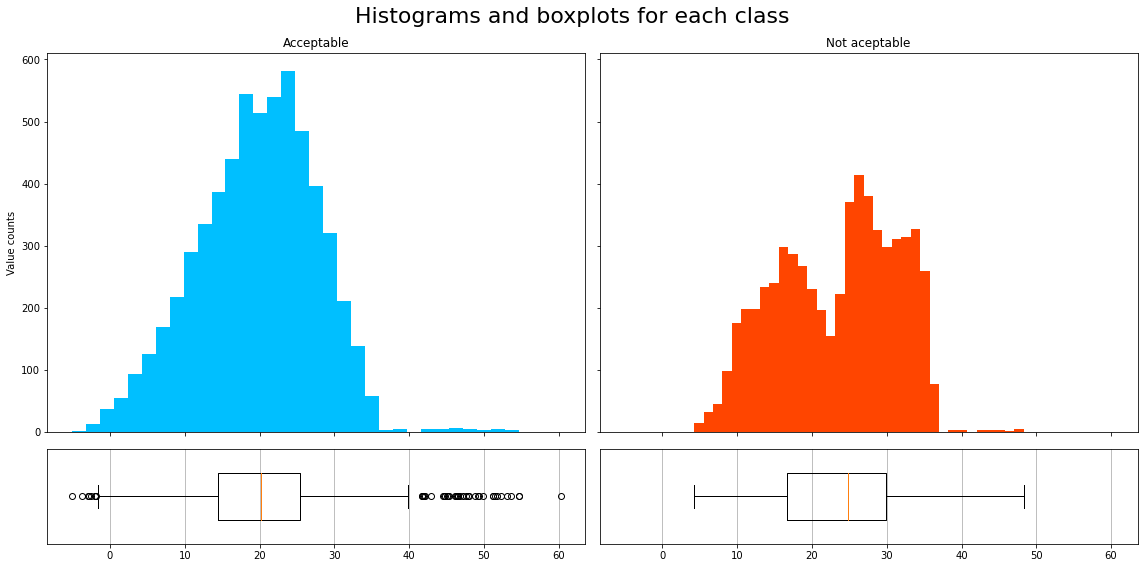

In [9]:
# histograms of the data
def plot_hist_of_data(data_df: pd.DataFrame, label_array: np.ndarray):
    n_bins = 35

    fig, axs = plt.subplots(2, 2, sharex="all", sharey="row", figsize=(16, 8), gridspec_kw={'height_ratios': [4, 1]})

    data_0 = data_df[np.where(label_array == +1)[0]]
    data_1 = data_df[np.where(label_array == -1)[0]]

    axs[0, 0].hist(data_0.to_numpy().flatten(), bins=n_bins, color=color_0)
    axs[0, 1].hist(data_1.to_numpy().flatten(), bins=n_bins, color=color_1)

    axs[0, 0].set_ylabel("Value counts")
    axs[0, 0].set_title(label_0)
    # axs[0, 0].grid(axis="x")
    axs[0, 1].set_title(label_1)
    # axs[0, 1].grid(axis="x")

    axs[1, 0].boxplot(data_0.to_numpy().flatten(), vert=False, widths=0.5)
    axs[1, 1].boxplot(data_1.to_numpy().flatten(), vert=False, widths=0.5)

    axs[1, 0].set_yticks([])
    axs[1, 0].grid(axis="x")
    axs[1, 1].grid(axis="x")

    fig.suptitle("Histograms and boxplots for each class", fontsize=22)
    fig.tight_layout()
    plt.show()
    
plot_hist_of_data(data_df=X_df, label_array=y)

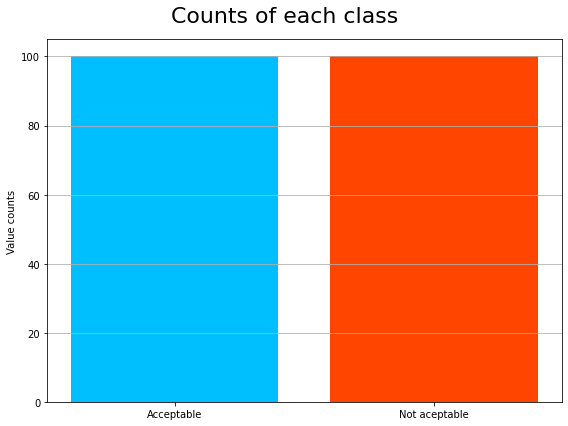

In [10]:
# barplot of the label
def plot_bar_of_label(label_array: np.ndarray):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 6))

    _, counts = np.unique(label_array, return_counts=True)
    counts = np.flip(counts)

    axs.bar([label_0, label_1], counts, color=[color_0, color_1])
    axs.set_ylabel("Value counts")
    axs.grid(axis="y")
    
    fig.suptitle("Counts of each class", fontsize=22)
    fig.tight_layout()
    plt.show()

plot_bar_of_label(label_array=y)

## EDA conclusions and plan ahead <a id="Plan"></a>

From the above visualizations of the data we can conclude the following:

- The classes are **balanced**. Therefore, **accuracy** is a valid metric for our model.
- The data for each class appears to be **easily distinguishable**. Threfore, we can be confident that there should be a model able to succesfully distinguish between them.
- There are **two outliers**, one in each class. Therefore, we need to handle them appropriately.

### Handle outliers

Let's look into the outliers:

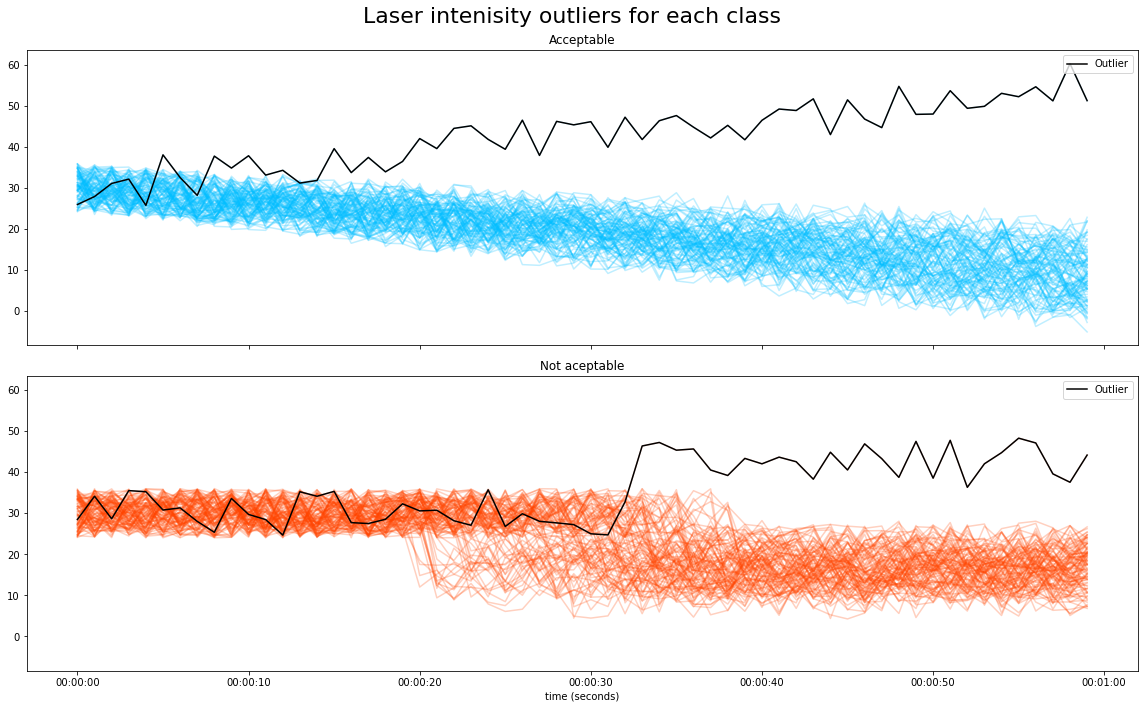

In [8]:
# plot outliers
def plot_outliers(data_df: pd.DataFrame, label_array: np.ndarray):
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 10))

    data_0 = data_df.iloc[:, np.where(label_array == +1)[0]]
    data_1 = data_df.iloc[:, np.where(label_array == -1)[0]]

    axs[0].plot(data_0, c=color_0, alpha=0.25)
    axs[0].plot(data_0.loc[:, (data_0.iloc[-1] >= 30)], label="Outlier", c="black")
    axs[1].plot(data_1, c=color_1, alpha=0.25)
    axs[1].plot(data_1.loc[:, (data_1.iloc[-1] >= 30)], label="Outlier", c="black")

    axs[0].set_title(label_0)
    axs[0].legend(loc="upper right")
    axs[1].set_title(label_1)
    axs[1].legend(loc="upper right")
    axs[1].set_xlabel("time (seconds)")

    fig.suptitle("Laser intenisity outliers for each class", fontsize=22)
    fig.tight_layout()
    plt.show()
    
plot_outliers(data_df=X_df, label_array=y)

From the plots above we can clearly see that the outliers don't follow their respective class trend. 

We could now try to "save" them by correcting the values. It seems that what went wrong with this outliers is the slope (flipping them around the x-axis would yield "normal" values).

However, this outliers represent $1%$ of the data, and since we don't have any insights into the data generating process, it is probably more reasonable to drop them for now.

In [9]:
# load raw data
laser_mat = loadmat("laser.mat")
X_raw = laser_mat["X"]
y_raw = laser_mat["Y"].flatten()

# drop the outliers
idx_to_keep = X_raw[:, -1] <= 30
X = X_raw[idx_to_keep]
y = y_raw[idx_to_keep]

X_df = construct_ts_df(X)

## Predictive models <a id="Models"></a>

### Naive models <a id="Naive-models"></a>

Given the simplicy of this naive models and since they are somehow "inappropriate" for time series data, I will spend **no time with hyperparameter tunning** in this section. For evaluating the model performance, I will use **stratified K-Fold cross validation** to estimate the model accuracy.

The use of accuracy as a performance metric is legitimate since the classes are balanced and we will be using the `StratifiedKFold` class.

#### Logisitc regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

Let's now apply the most naive of models: treat time-series data as tabular data and perform logistic regression (log-linear classification).

This means that we will take the 60 seconds of data and handle them as 60 dimensional feature vectors, each second as a feature. This approach doesn't make any use of the sequential nature of the time-series data and it is intuitively a bad idea because it wouldn't scale well with larger time-series.

In [42]:
# instanciate the classifier, spliter and scores list
log_clf = LogisticRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# scale the data
X_scaled = MinMaxScaler().fit_transform(X.T).T

# K-Fold CV
for train_idx, test_idx in tqdm(skf.split(X_scaled, y)):
    X_train, y_train = X_scaled[train_idx], y[train_idx]
    log_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X_scaled[test_idx], y[test_idx]
    scores.append(log_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(log_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# # finally we train a model with all the data
# log_clf.fit(X=X_scaled, y=y)

0it [00:00, ?it/s]

The average accuracy is: 0.9343589743589744


In [12]:
%%timeit
# finally we train a model with all the data
log_clf.fit(X=X_scaled, y=y)

6.8 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%%timeit
# finally we train a model with all the data
log_clf.predict(X=X_scaled[test_idx])

50.6 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Surprisingly this approach performs **better than I had expected**.

Finally, to try to undersand how this model is able to successfully classify the data, it is worth lookign at the value of the learned coefficients:

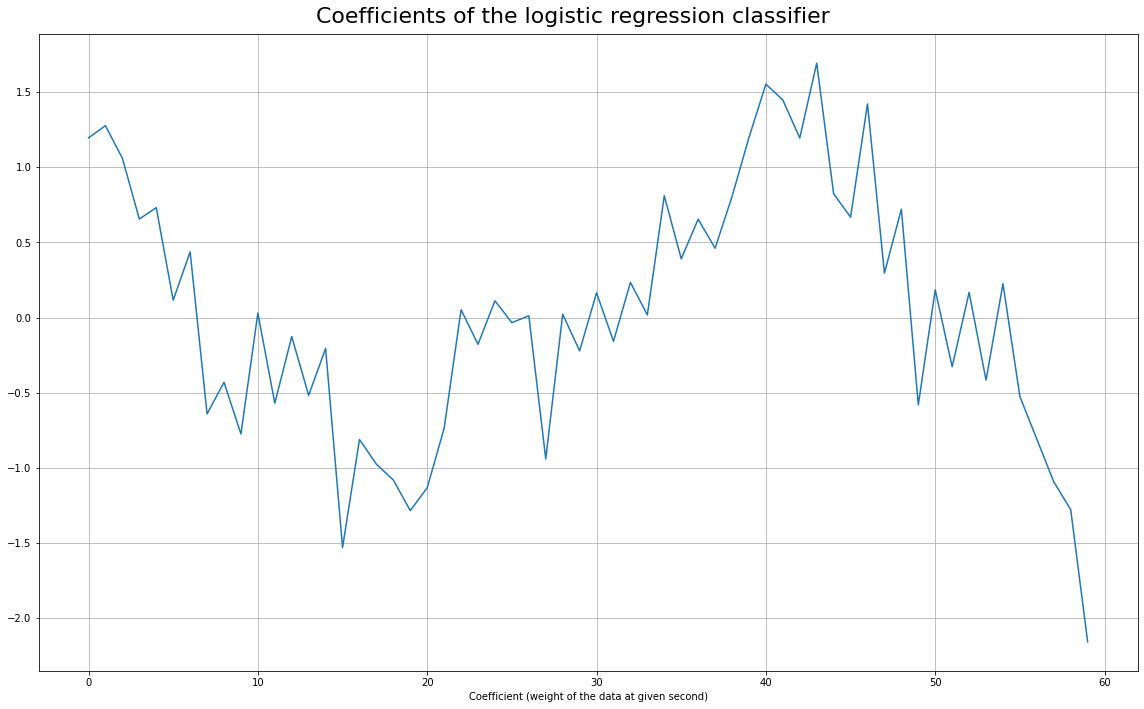

In [14]:
# barplot of the label
def plot_log_clf_coeffs(coeffs: np.ndarray):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 10))

    axs.plot(coeffs)
    axs.set_xlabel("Coefficient (weight of the data at given second)")
    axs.grid()
    
    fig.suptitle("Coefficients of the logistic regression classifier", fontsize=22)
    fig.tight_layout()
    plt.show()

plot_log_clf_coeffs(coeffs=log_clf.coef_.flatten())

From the plot above we can observe that if the laser signal is:
- larger around the 20th second, then it is likely to be not acceptable
- larger around the 40th second, then it is likely to be acceptable

This makes sense with the profile of the data we observed in the EDA step.

#### Decision tree with descriptive statisitcs

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Let's now be a bit more creative and use descriptive statistics of the data to train a decission tree classifier.

This approach completly ignores the fact that the data at hand is time-series. Here the idea is that this statistics (min, max, mean, etc.) might contain sufficient infromation to determine if a laser is acceptable.

In [44]:
# instanciate the classifier, spliter and scores list
tree_clf = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# construct the descriptive statistics data
descriptive = ["min", "max", "mean", "std", "sum", "argmin", "argmax", "first", "last"]
X_descriptive = np.array([X.min(axis=1),
                          X.max(axis=1),
                          X.mean(axis=1),
                          X.std(axis=1),
                          X.sum(axis=1),
                          X.argmin(axis=1),  # position of the min
                          X.argmax(axis=1),  # position of the max
                          X[:, 0],  # first value
                          X[:, -1]  # last value 
                         ], dtype=np.float32).T

# K-Fold CV
for train_idx, test_idx in tqdm(skf.split(X_descriptive, y)):
    X_train, y_train = X_descriptive[train_idx], y[train_idx]
    tree_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X_descriptive[test_idx], y[test_idx]
    scores.append(tree_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(tree_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# finally we train a model with all the data
tree_clf.fit(X=X_descriptive, y=y)

0it [00:00, ?it/s]

The average accuracy is: 0.9396153846153847


DecisionTreeClassifier(random_state=42)

In [17]:
%%timeit
# finally we train a model with all the data
tree_clf.fit(X=X_descriptive, y=y)

834 µs ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
%%timeit
# finally we train a model with all the data
tree_clf.predict(X=X_descriptive[test_idx])

50.3 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Once again, the performance of this approach **exceeds my expectations**.

To better understand this model, we look at the feature importances and at the decision tree of the model trained with all the data:

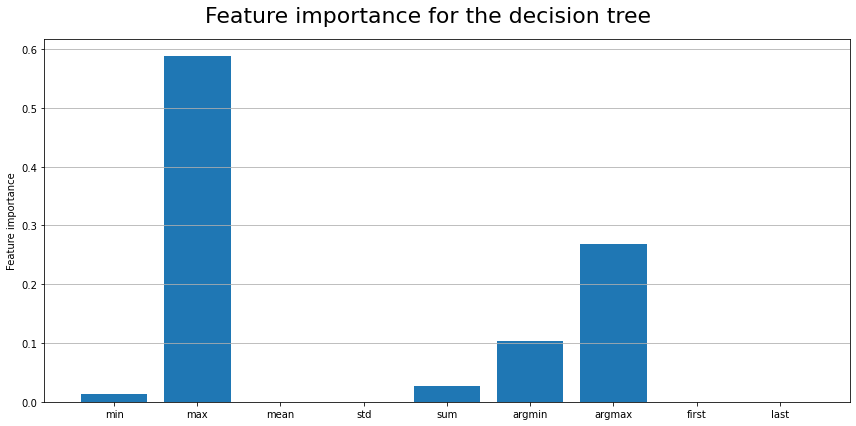

In [19]:
# barplot of the feature importances
def plot_bar_feature_importance(imp: np.ndarray, feature_names):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))

    axs.bar(feature_names, imp)
    axs.set_ylabel("Feature importance")
    axs.grid(axis="y")
    
    fig.suptitle("Feature importance for the decision tree", fontsize=22)
    fig.tight_layout()
    plt.show()

plot_bar_feature_importance(imp=tree_clf.feature_importances_, feature_names=descriptive)

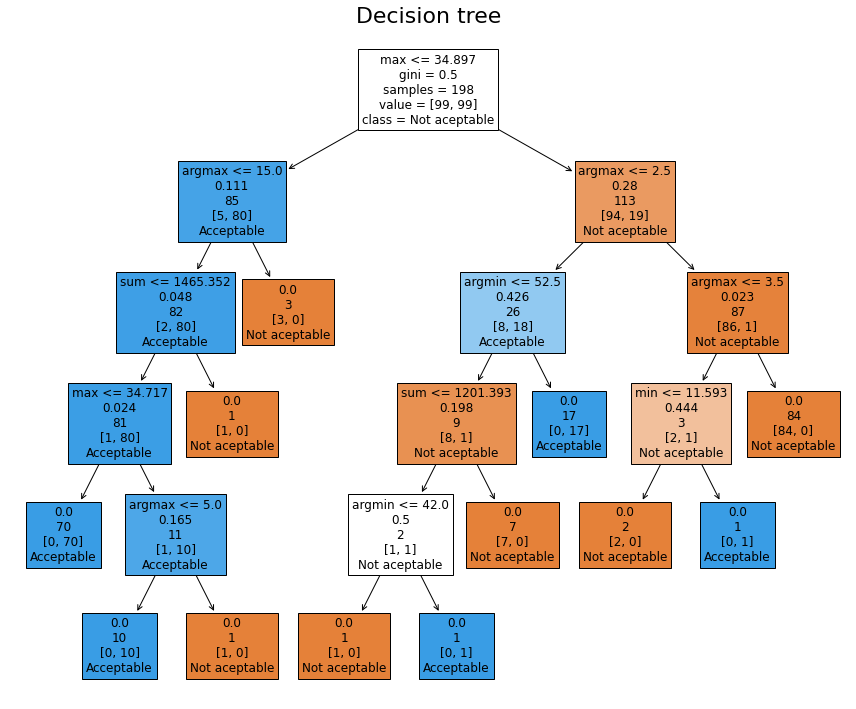

In [20]:
# plot tree classifier
def plot_tree_clf(clf, feature_names):
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 10))

    plot_tree(clf, feature_names=feature_names, ax=axs, fontsize=12, 
                   class_names=[label_1, label_0], label="root", filled=True)

    fig.suptitle("Decision tree", fontsize=22)
    fig.tight_layout()
    plt.show()

plot_tree_clf(clf=tree_clf, feature_names=descriptive)

From the plot and tree shown above, one sees that the maximum is the most important feature, while the mean or the standard deviation are not even used. The fact that the mean is not used by this decision tree is worth mentioning, because during the EDA we observed that the mean of the two classes are, in fact, different.

### Appropriate models <a id="Appropriate-models"></a>

In this section we will implement and explore models that are "up to the task" in the sense that they are time-series oriented. Therefore, here I will perform **hyperparameter tunning using nested cross validation** 

#### Baseline: DTW (with euclidean distance) and 1-NN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Let's now jump into what we will take as our baseline. We will use Dynamic Time Wrappping (DTW) to measure the distance between any two time-series and then we will classify the data with 1-Nearest Neighbours, meaning that for a given (test) sample we will predict the class of the closest training sample.

We recover the `d_DTW` function from the course labs (lab 10):

In [22]:
def d_DTW(x, x2, dist):
    t1, t2 = len(x), len(x2)
    
    #Edge Cases
    
    if (len(x) == 0) and (len(x2) == 0):
        return 0.0
    elif (len(x) == 0) or (len(x2) == 0):
        return np.infty
    
    dp = np.zeros((t1+1, t2+1)) # use .zeros since .empty caused issues
    dp[0, 0] = 0
    
    for i in range(1, t1+1):
        dp[i, 0] = np.infty
    
    for j in range(1, t2+1):
        dp[0, j] = np.infty
        
    #Standard Procedure
    
    # WRITE YOUR CODE HERE
    for i in range(t1):
        for j in range(t2):
            xi_x2j_dist = dist(x[i], x2[j])
            xi_x2j_min = np.min([dp[i-1, j-1], dp[i-1, j], dp[i, j-1]])
            dp[i+1, j+1] = xi_x2j_dist + xi_x2j_min
    
    return dp[t1, t2]

Here the `dist` argument is an hyperparameter, which we would need to tune appropriately. However, we are now focusing on our baseline model, and therefore we will use the eucliedean distance:

 $d_{euc}(x_1, x_2) = (x_1 - x_2)^2$,

In [23]:
def d_euc(x, x2):
    return (x - x2)**2

We can now perform cross validation to find the accuracy of our **baseline** model.

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1, metric=d_DTW, metric_params={"dist": d_euc})
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# K-Fold CV
for train_idx, test_idx in tqdm(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    knn_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X[test_idx], y[test_idx]
    scores.append(knn_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(knn_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# finally we train a model with all the data
knn_clf.fit(X=X, y=y)

0it [00:00, ?it/s]

The average accuracy is: 0.9897435897435898


KNeighborsClassifier(metric=<function d_DTW at 0x7fe6bc8ee430>,
                     metric_params={'dist': <function d_euc at 0x7fe6bcafd310>},
                     n_jobs=-1, n_neighbors=1)

In [39]:
%%timeit
# finally we train a model with all the data
knn_clf.fit(X=X, y=y)

133 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit
# finally we train a model with all the data
knn_clf.predict(X=X_test)

2min 42s ± 344 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This model performs considerably well, however, the fitting/predicting time of around two minutes seems too long to me. After doing some research I have come across a python module called [`sktime`](https://www.sktime.org/en/stable/index.html) that provides a framework for time-series machine lerning. This module has most of the models I mentioned previously already implemented, so let's give it a spin and see if it speeds up the fitting/predicting time.

In [24]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [25]:
knn_ts_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, n_jobs=-1, distance="dtw")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# K-Fold CV
for train_idx, test_idx in tqdm(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    knn_ts_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X[test_idx], y[test_idx]
    scores.append(knn_ts_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(knn_ts_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# finally we train a model with all the data
knn_ts_clf.fit(X=X, y=y)

0it [00:00, ?it/s]

The average accuracy is: 0.9898717948717948


KNeighborsTimeSeriesClassifier(n_jobs=-1)

In [26]:
%%timeit
# finally we train a model with all the data
knn_ts_clf.fit(X=X, y=y)

2.87 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit
# finally we train a model with all the data
knn_ts_clf.predict(X=X_test)

212 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While the fitting/predicting time has been greately reduced, the model average accuracy is very similar. This leads me to believe that both of the 1-NN models above boil down to the same logic, but the implementations differ and this causes the **remarkable time reduction**.

> Notice that the `.fit()` function call runs faster for the `sklearn` model. It seems that the `.score()` (which calls `.predict()` under the hood) call is what is consuming most of the time in the `sklearn` implementation.

#### Evaluation and tunning strategy: Nested K-fold Cross Validation

Before we jump into the different "appropriate" models we need to decide **how to evaluate** our models and **how to tune** their hyperparameters. We have already argued that since we have balanced classes, **accuracy** is a valid metric. Since we are tackling a classification task, we could consider other metrics such as precision-recall and ROC curves, however, we will use accuracy for now.

Now the question is: How do we split the data to train/tune/test so that we get a good estimate of the model accuracy and we can tune the hyperparameters?

For this we will use **Nested K-fold Cross Validation**. The ise is to split the data in training/tunning/testing sets in a rotating fashion. This is better understood with the diagram from the lecture notes (credits to the teaching staff of ML1 at Uni Potsdam):

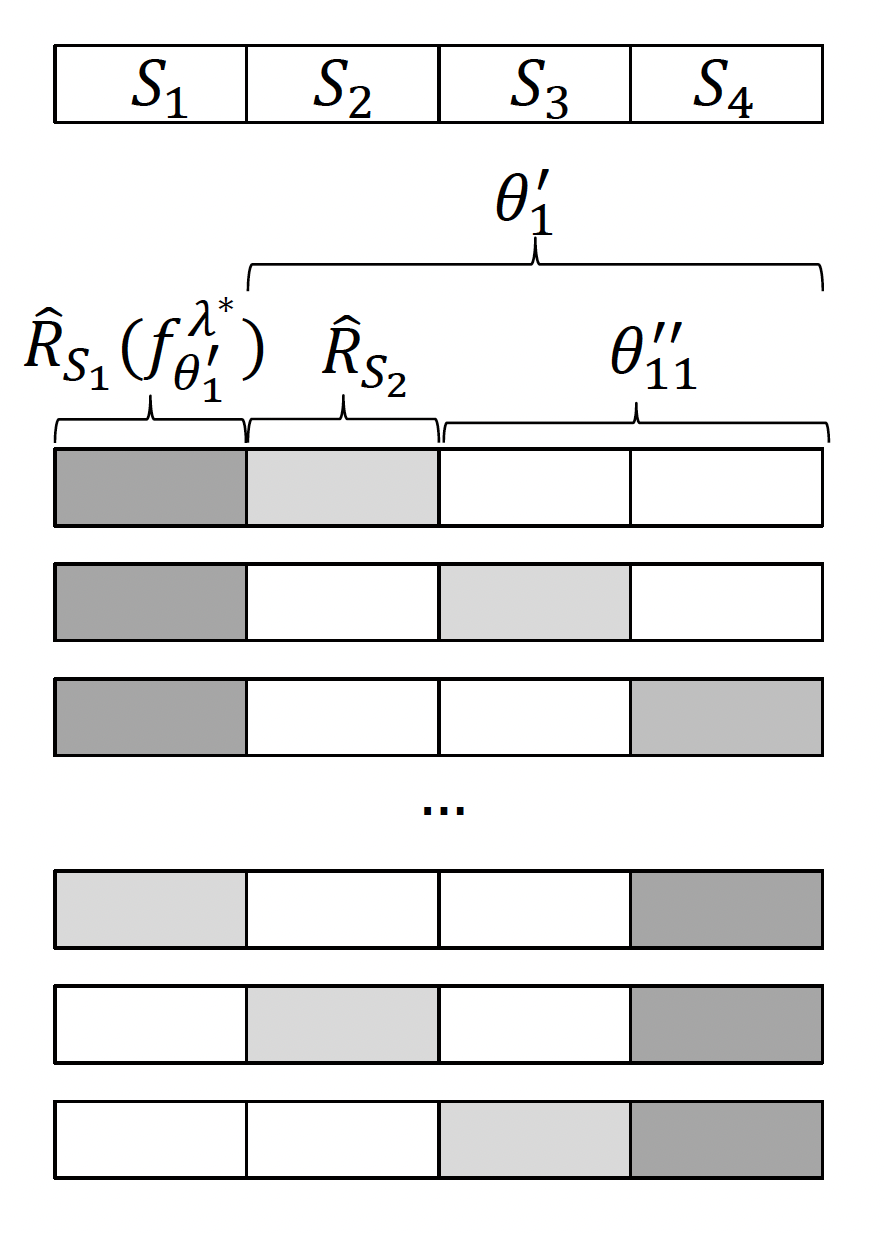
</img>

To implement this in the best way possible, I have followed [the guide provided by Sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) as a reference. However, to determine the hyperparmeters I had to add some modificaitons. To this end, the following `nested_Kfold_CV` function does all the steps:

In [28]:
def nested_Kfold_CV(X_data, y_data, classifier, params_grid, outer_k=5, inner_k=5):
    
    outer_skf = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)
    scores = []

    # nested K-Fold CV
    for train_idx, test_idx in tqdm(outer_skf.split(X_data, y_data)):
        X_train, y_train = X[train_idx], y[train_idx]

        # do grid search on the training data (using training and tunning data)
        inner_skf = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)
        gs_clf = GridSearchCV(estimator=classifier, param_grid=params_grid, cv=inner_skf)
        gs_clf.fit(X=X_train, y=y_train)

        # get the best estimator (best hyperparameters)
        best_clf = gs_clf.best_estimator_
        # train the best estimator with the whole training data
        best_clf.fit(X=X_train, y=y_train)

        X_test, y_test = X[test_idx], y[test_idx]
        scores.append(best_clf.score(X=X_test, y=y_test))
        print(f"The best {len(scores)}-th model scored {scores[-1]:.3f} \twith hyperparameters: {gs_clf.best_params_}")

    scores = np.array(scores)

    print(f"The average accuracy is: {scores.mean()}")

    # to find the best hyperparameters we'll perform grid search on the outer CV
    outer_gs_clf = GridSearchCV(estimator=classifier, param_grid=params_grid, cv=outer_skf)
    outer_gs_clf.fit(X=X_data, y=y_data)

    print(f"The selected hyperparameters are: {outer_gs_clf.best_params_}")

    # # finally we train a model with all the data
    classifier.set_params(**outer_gs_clf.best_params_)
    return classifier.fit(X=X_data, y=y_data)


#### (INGORE - NOT USING `sktime`, TAKES TOO LONG) DTW and k-NN

Let's now "properly" train and tune a model. We will use the same model as above, but this time we will tune the hyperparameters appropriately. These are the distance (`dist`) and the number of neighbours used in the nearest neighbours voting (`n_neighbors`) also referred to as simply `k`.

The options for the distance measure `dist` are infinite, but here we will only explore the following three:

 $d_{euc}(x_1, x_2) = (x_1 - x_2)^2$,
 
 $d_1(x_2, x_2) = \mathbb{1}[x_1 != x_2]$, (a boolean Value should be returned)

 $d_3(x_1, x_2) = |x_1 - x_2|$
 
The options for `k` are all odd natural numbers, but to constrain the search space we will limit it to `[1, 3, 5, 7]`.

In [149]:
def d_euc(x, x2):
    return (x - x2)**2

def d1(x, x2):
    return True if x != x2 else False

def d3(x, x2):
    return np.abs(x - x2)

For the hyperparameter tunning we will use nested CV as described above.

In [163]:
knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1, metric=d_DTW, metric_params={"dist": d_euc})
knn_params_grid = {
    "n_neighbors": [1, 3, 5, 7],
    "metric_params": [{"dist": d_euc}, {"dist": d1}, {"dist": d3}]
}

outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# nested K-Fold CV
for train_idx, test_idx in tqdm(outer_skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    
    # do grid search on the training data (using training and tunning data)
    inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gs_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=knn_params_grid, cv=inner_skf)
    gs_knn_clf.fit(X=X_train, y=y_train)
    
    # get the best estimator (best hyperparameters)
    best_knn_clf = gs_knn_clf.best_estimator_
    # train the best estimator with the whole training data
    best_knn_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X[test_idx], y[test_idx]
    scores.append(best_knn_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(knn_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# to find the best hyperparameters we'll perform grid search on the outer CV
outer_gs_knn_clf = GridSearchCV(estimator=knn_clf, param_grid=knn_params_grid, cv=outer_skf)
outer_gs_knn_clf.fit(X=X, y=y)

print(f"The selected hyperparameters are: {outer_gs_knn_clf.best_params_}")

# # finally we train a model with all the data
# knn_clf.fit(X=X, y=y)

5it [8:42:17, 6267.51s/it]


The average accuracy is: 0.9948717948717949
The selected hyperparameters are: {'metric_params': {'dist': <function d_euc at 0x7ffc2e1e35e0>}, 'n_neighbors': 7}


#### (USING `sktime`) DTW and k-NN

After the long fitting/predicting time of the previous model...

Now I will be using the `sktime` module, which has the `KNeighborsTimeSeriesClassifier` implemented. Different to the implementation we used in lab 8, here the DTW distance does not allow for different metrics, but there are different distances available.

The classifier has the following hyperparameters ([class documentation](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.classification.distance_based.KNeighborsTimeSeriesClassifier.html)):
- `n_neighbors`: number of neighbors to use.
- `algorithm`: algorithm to use for neighbours search. This mostly affects performance, but not the result.
- `distance`: distance to use when computing the distance between two time-series. Details on some of the DTW-related options can be found [here](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.dists_kernels.dtw.DtwDist.html#sktime.dists_kernels.dtw.DtwDist).
- `leaf_size`: this relates to the algorithm used. When using tree algorithms, this controls the size of the leafs.

For some reason I have not been able to sort out, setting `ball_tree` and `kd_tree` methods in `algorithm`, leads to an error. Therefore, I have excluded those from the grid search.

In [29]:
knn_ts_clf_2 = KNeighborsTimeSeriesClassifier(n_jobs=-1)
knn_ts_clf_2_params_grid = {
    "n_neighbors": [1, 3, 5, 7, 9],
    "distance": ["euclidean", "squared", "dtw", "ddtw", "wdtw", "wddtw", "lcss", "edr", "erp", "msm", "twe"],
#     "algorithm": ["ball_tree", "kd_tree", "brute"],
#     "leaf_size": [10, 20]
}

knn_ts_clf_2 = nested_Kfold_CV(X, y, knn_ts_clf_2, knn_ts_clf_2_params_grid)

0it [00:00, ?it/s]

The best 1-th model scored 1.000 	with hyperparameters: {'distance': 'dtw', 'n_neighbors': 3}
The best 2-th model scored 1.000 	with hyperparameters: {'distance': 'dtw', 'n_neighbors': 7}
The best 3-th model scored 0.975 	with hyperparameters: {'distance': 'dtw', 'n_neighbors': 1}
The best 4-th model scored 0.974 	with hyperparameters: {'distance': 'dtw', 'n_neighbors': 1}
The best 5-th model scored 1.000 	with hyperparameters: {'distance': 'dtw', 'n_neighbors': 3}
The average accuracy is: 0.9898717948717948
The selected hyperparameters are: {'distance': 'dtw', 'n_neighbors': 3}


In [30]:
%%timeit
# finally we train a model with all the data
knn_ts_clf_2.fit(X=X, y=y)

3.48 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%%timeit
# finally we train a model with all the data
knn_ts_clf_2.predict(X=X[test_idx])

205 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Time Series Forest

In [32]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

Let's now use an ensemble model. A Time Series Forest (TSF) is an adaptation of a Random Forest to time-series classification. 

TSF generates an ensamble of desicion trees (forest) that split the data in random intervals and calculate some descriptive statisitcs (mean, std and slope) for each interval, then each decision tree is trained with this new interval based features.

Here I will use the `sktime` library, which has this classifier implemented. It is worth mentioning that the configurability of this model is not much and one could use the `sklearn.tree.DecisionTreeClassifier` as the basis to build a more configurable TSF.

The TSF classifier from `sktime` has two hyperparameters:
- `n_estimators`: number of decision trees in the forest
- `min_interval`: minimum length of the intervals

Again, for hyperparameter tunning and accuracy estimation we will use nested cross validation.

For `n_estimators`, it's normally the case that the more the better. However, this comes at the cost of longer training time. Here we will explore `[100, 200, 300, 400]`.

For `min_interval`, we will limit the search to `[3, 6, 9, 15, 20]`. Recall that our data has 60 points, and therefore a minimum length of 20 is alredy a quite large interval.

In [33]:
tsf_clf = TimeSeriesForestClassifier(n_jobs=-1)
tsf_params_grid = {
    "n_estimators": [25, 50, 100, 200],
    "min_interval": [3, 6, 9, 15, 20]
}

tsf_clf = nested_Kfold_CV(X, y, tsf_clf, tsf_params_grid)

0it [00:00, ?it/s]

The best 1-th model scored 0.975 	with hyperparameters: {'min_interval': 3, 'n_estimators': 50}
The best 2-th model scored 1.000 	with hyperparameters: {'min_interval': 3, 'n_estimators': 100}
The best 3-th model scored 0.975 	with hyperparameters: {'min_interval': 3, 'n_estimators': 50}
The best 4-th model scored 1.000 	with hyperparameters: {'min_interval': 6, 'n_estimators': 200}
The best 5-th model scored 0.974 	with hyperparameters: {'min_interval': 6, 'n_estimators': 50}
The average accuracy is: 0.9848717948717949
The selected hyperparameters are: {'min_interval': 6, 'n_estimators': 25}


In [34]:
%%timeit
# finally we train a model with all the data
tsf_clf.fit(X=X, y=y)

49.7 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%%timeit
# finally we train a model with all the data
tsf_clf.predict(X=X[test_idx])

19.7 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Random Interval Spectral Ensemble

In [36]:
from sktime.classification.interval_based import RandomIntervalSpectralEnsemble

In [37]:
rise_clf = RandomIntervalSpectralEnsemble(min_interval=20, max_interval=12)
rise_clf.get_params()

{'acf_lag': 100,
 'acf_min_values': 4,
 'max_interval': 12,
 'min_interval': 20,
 'n_estimators': 500,
 'n_jobs': 1,
 'random_state': None}

Given the good performance and speed of the TSF model, let's go for an ensamble method that uses spectral (frequency based) features, the Random Interval Spectral Ensemble (RISE).

RISE works similarly to TSF in the sense that it uses an ensamble of decision trees with features extracted from random intervals, but there are two worth-mentioning differences:
- RISE uses only one interval to extract features for each decision tree.
- RISE uses spectral features instead of descriptive statistics.

The spectral features used by RISE are the autocorrelation function (ACF), partial autocorrelation function (PACF) and the power spectrum (PS). The two first features are measures of interdependence between subsequent data points, while the PS measures the weight of the frequencies composing the signal.

Again, I will use the `sktime` module and tune the exposed parameters of the `RandomIntervalSpectralEnsemble` model.

The hyperparameters are:
- `n_estimators`: number of decision trees in the forest
- `min_interval`: minimum length of the intervals
- `max_interval`: maximum length of the intervals
- `acf_lag`: maximum number of terms to use in ACF
- `acf_min_values`: minimum number of term to use in ACF

For tunning all this parameters regular Grid Search would take a very long time and might not be the most efficient approach. This is why I will do a three-step search, by first tunning the more specific parameters and then the more general ones:
1. Tune the ACF related parameters with a large ensamble and wide intervals
2. Tune the intervals with a large ensamble
3. Tune the ensamble size

In [41]:
rise_clf = RandomIntervalSpectralEnsemble(n_jobs=-1)
rise_params_grid = {
    "n_estimators": [300],
    "min_interval": [3],
    "max_interval": [60],
    "acf_lag": [21, 30, 40, 50, 60],
    "acf_min_values": [5, 10, 20]
}

rise_clf = nested_Kfold_CV(X, y, rise_clf, rise_params_grid)

0it [00:00, ?it/s]

The best 1-th model scored 1.000 	with hyperparameters: {'acf_lag': 30, 'acf_min_values': 5, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}
The best 2-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 5, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}
The best 3-th model scored 0.925 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 5, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}
The best 4-th model scored 1.000 	with hyperparameters: {'acf_lag': 40, 'acf_min_values': 5, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}
The best 5-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 5, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}
The average accuracy is: 0.985
The selected hyperparameters are: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 60, 'min_interval': 3, 'n_estimators': 300}


In [48]:
rise_clf.get_params()

{'acf_lag': 21,
 'acf_min_values': 10,
 'max_interval': 60,
 'min_interval': 3,
 'n_estimators': 300,
 'n_jobs': -1,
 'random_state': None}

In [49]:
rise_params_grid = {
    "n_estimators": [300],
    "min_interval": [3, 6, 9, 15, 20],
    "max_interval": [21, 40, 60],
    "acf_lag": [21],
    "acf_min_values": [10]
}

rise_clf = nested_Kfold_CV(X, y, rise_clf, rise_params_grid)

0it [00:00, ?it/s]

The best 1-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 40, 'min_interval': 9, 'n_estimators': 300}
The best 2-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 15, 'n_estimators': 300}
The best 3-th model scored 0.950 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 40, 'min_interval': 9, 'n_estimators': 300}
The best 4-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 60, 'min_interval': 6, 'n_estimators': 300}
The best 5-th model scored 0.974 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 40, 'min_interval': 20, 'n_estimators': 300}
The average accuracy is: 0.9848717948717949
The selected hyperparameters are: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 300}


In [50]:
rise_clf.get_params()

{'acf_lag': 21,
 'acf_min_values': 10,
 'max_interval': 21,
 'min_interval': 6,
 'n_estimators': 300,
 'n_jobs': -1,
 'random_state': None}

In [51]:
rise_params_grid = {
    "n_estimators": [25, 50, 100, 200, 300],
    "min_interval": [6],
    "max_interval": [21],
    "acf_lag": [21],
    "acf_min_values": [10]
}

rise_clf = nested_Kfold_CV(X, y, rise_clf, rise_params_grid)

0it [00:00, ?it/s]

The best 1-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 100}
The best 2-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 200}
The best 3-th model scored 0.950 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 100}
The best 4-th model scored 0.974 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 50}
The best 5-th model scored 1.000 	with hyperparameters: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 100}
The average accuracy is: 0.9848717948717949
The selected hyperparameters are: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 100}


Since I have used this search method, I feel like steping back and performing simple cross validation withe the final model is the best way to report a model accuracy.

In [54]:
rise_clf = RandomIntervalSpectralEnsemble(acf_lag=21, acf_min_values=10,
                                          max_interval=21, min_interval=6,
                                          n_estimators=100)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# K-Fold CV
for train_idx, test_idx in tqdm(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    rise_clf.fit(X=X_train, y=y_train)
    
    X_test, y_test = X[test_idx], y[test_idx]
    scores.append(rise_clf.score(X=X_test, y=y_test))

#     RocCurveDisplay.from_estimator(knn_clf, X_test, y_test)
    
# plt.show()
scores = np.array(scores)

print(f"The average accuracy is: {scores.mean()}")

# finally we train a model with all the data
rise_clf.fit(X=X, y=y)

0it [00:00, ?it/s]

The average accuracy is: 0.974871794871795


RandomIntervalSpectralEnsemble(acf_lag=21, acf_min_values=10, max_interval=21,
                               min_interval=6, n_estimators=100)

In [55]:
%%timeit
# finally we train a model with all the data
rise_clf.fit(X=X, y=y)

1.78 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
# finally we train a model with all the data
rise_clf.predict(X=X[test_idx])

339 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Overkill models <a id="Overkill-models"></a>

Although at the beginning of the project I hoped to reach this point with enough time and capacity to implement some of this "for fun" models, I have to leave this chapter empty... For now.

## Conclusions and final discussion <a id="Conclusions"></a>


|              | Model                                                       |  Estimated accuracy |   Training Time  |  Predicting Time  |
|--------------|-------------------------------------------------------------|---------------------|------------------|-------------------|
|              | Logisitc regression                                         |       93.435 %      | 6.8 ms           |   57.7 µs         | 
|              | Decision tree (w. descriptive stats)                        |       93.423 %      | 834 µs           |   57.8 µs         |
| **Baseline** (`sklearn`) | DTW 1-NN                                        |       98.974 %      | 133 µs           |   2min 42s        |
| **Baseline** (`sktime`)  | DTW 1-NN                                        |       98.987 %      | 2.8 ms           |   212 ms          |
|              | DTW 3-NN                                                    |       98.987 %      | 3.48 ms          |   205 ms          |
|              | Time Series Forest                                          |       98.487 %      | 49.7 ms          |   19.7 ms         |
|              | Random Interval Spectral Ensemble                           |       97.487 %      | 1.78 s           |    339 ms         |

Where the hyperparameters are:
- TSF: {'min_interval': 6, 'n_estimators': 25}
- RISE: {'acf_lag': 21, 'acf_min_values': 10, 'max_interval': 21, 'min_interval': 6, 'n_estimators': 100}


The best performing models are the baseline (DTW 1-NN) and it's variation (DTW 3-NN). This are not only the most accurate, but also realively fast, only beaten on speed by the TSF.

It is worth mentioning that the accuracy of the RISE has been calculated using a slightly different process, and it could be that due to differences in the train/test splits the estimate is a bit pessimistic.

### Discussion:

It should be noted that while the "naive" models seems good at first, using "appropriate" models yields a 5% increase in accuracy.

It is a bit surprising to me that the DTW k-NN model was not able to beat the baseline DTW 1-NN by leveraging more neighbours.

I also had higher hopes for the frequency-based RISE model, since it uses spectral features and I expected them to be more informative.

All in all, I beleive that the models implemented and tested above are performing considerably well.